In [0]:
# imports
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from google.colab import drive 
import seaborn as sns
drive.mount('/content/gdrive')
import math

# allow plots to appear directly in the notebook
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
training_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/TRAINING_DATA.txt', sep=",") # read in training data into a DataFrame
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
so2               300 non-null float64
car.count         300 non-null float64
wind.velocity     300 non-null float64
wind.direction    300 non-null int64
time.of.day       300 non-null int64
day.index         300 non-null int64
temperature.1     300 non-null float64
temperature.30    300 non-null float64
dtypes: float64(5), int64(3)
memory usage: 18.9 KB


In [0]:
training_df.drop_duplicates(keep='first',inplace=True) # drop duplicate rows from training data
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 298
Data columns (total 8 columns):
so2               138 non-null float64
car.count         138 non-null float64
wind.velocity     138 non-null float64
wind.direction    138 non-null int64
time.of.day       138 non-null int64
day.index         138 non-null int64
temperature.1     138 non-null float64
temperature.30    138 non-null float64
dtypes: float64(5), int64(3)
memory usage: 9.7 KB


In [0]:
testing_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/TESTING_DATA.txt', sep=",") # read in testing data
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
car.count         200 non-null float64
wind.velocity     200 non-null float64
wind.direction    200 non-null int64
time.of.day       200 non-null int64
day.index         200 non-null int64
temperature.1     200 non-null float64
temperature.30    200 non-null float64
dtypes: float64(4), int64(3)
memory usage: 11.1 KB


In [0]:
training_df.head()

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
0,169.099957,1430.000396,1.3,114,21,50,-1.7,-0.3
1,51.000223,2328.990055,2.5,83,20,98,-5.4,-4.0
2,20.299982,2884.999484,2.2,44,18,189,9.8,9.8
3,68.799742,3542.011269,5.9,214,16,108,4.2,4.5
4,82.000062,2531.000606,0.5,296,15,184,8.9,8.3


In [0]:
training_df.describe() # summary statistics for training data covariates and variables

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,53.031164,1692.253413,2.976812,150.072464,12.427536,120.492754,0.731159,0.984058
std,36.981334,1151.827811,1.770739,84.205574,6.958572,53.329474,6.005944,5.784061
min,3.900013,81.000068,0.300000,3.000000,1.000000,32.000000,-18.600000,-17.800000
25%,25.425026,685.251004,1.700000,79.000000,7.000000,78.250000,-3.250000,-3.050000
50%,46.700001,1719.008044,2.800000,114.500000,13.000000,116.000000,1.650000,2.100000
75%,70.374913,2446.757055,3.875000,220.750000,18.000000,167.750000,4.975000,5.100000
max,265.700571,4224.009186,9.900000,359.000000,24.000000,212.000000,12.200000,11.500000


In [0]:
# Create a feature to capture dynamic pressure from wind

rho = 1.225 # density of air in kg/m^3

training_df["dynamic_pressure"] = 1/2*rho*training_df['wind.velocity']**2 # dynamic pressure of the wind speed in kPa
testing_df["dynamic_pressure"] = 1/2*rho*testing_df['wind.velocity']**2 # dynamic pressure of the wind speed kPa

In [0]:
# Create a new feature to index the month of the observation

training_df["month"] = 0 

training_df.loc[training_df["day.index"] >= 29, "month"] = 3 
training_df.loc[training_df["day.index"] >= 60, "month"] = 4 
training_df.loc[training_df["day.index"] >= 90, "month"] = 5 
training_df.loc[training_df["day.index"] >= 121, "month"] = 6 
training_df.loc[training_df["day.index"] >= 151 , "month"] = 7 
training_df.loc[training_df["day.index"] >= 182, "month"] = 8 

testing_df["month"] = 0 

testing_df.loc[testing_df["day.index"] >= 29, "month"] = 3 
testing_df.loc[testing_df["day.index"] >= 60, "month"] = 4 
testing_df.loc[testing_df["day.index"] >= 90, "month"] = 5 
testing_df.loc[testing_df["day.index"] >= 121, "month"] = 6 
testing_df.loc[testing_df["day.index"] >= 151, "month"] = 7 
testing_df.loc[testing_df["day.index"] >= 182, "month"] = 8 


training_df.describe()

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30,dynamic_pressure,month
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,53.031164,1692.253413,2.976812,150.072464,12.427536,120.492754,0.731159,0.984058,7.334199,5.492754
std,36.981334,1151.827811,1.770739,84.205574,6.958572,53.329474,6.005944,5.784061,8.978540,1.739395
min,3.900013,81.000068,0.300000,3.000000,1.000000,32.000000,-18.600000,-17.800000,0.055125,3.000000
25%,25.425026,685.251004,1.700000,79.000000,7.000000,78.250000,-3.250000,-3.050000,1.770125,4.000000
50%,46.700001,1719.008044,2.800000,114.500000,13.000000,116.000000,1.650000,2.100000,4.802000,5.000000
75%,70.374913,2446.757055,3.875000,220.750000,18.000000,167.750000,4.975000,5.100000,9.198219,7.000000
max,265.700571,4224.009186,9.900000,359.000000,24.000000,212.000000,12.200000,11.500000,60.031125,8.000000


In [0]:
# Create a new feature to measure the temperature gradient between 30

training_df['temp.gradient'] = training_df["temperature.30"] - training_df["temperature.1"]
testing_df['temp.gradient'] = testing_df["temperature.30"] - testing_df["temperature.1"]

In [0]:
# Create a new feature to indicate whether the SO2 reading was made during the summer (June or later)

training_df["summer?"] = 0
training_df.loc[training_df["month"] >= 6, "summer?"] = 1

testing_df["summer?"] = 0
testing_df.loc[testing_df["month"] >= 6, "summer?"] = 1

In [0]:
# Create new features to indicate which day of the week the SO2 reading was made and whether it was made during the weekend

training_df["day.of.week"] = ((training_df["day.index"]-1)%7)
testing_df["day.of.week"] = ((testing_df["day.index"]-1)%7)

training_df["weekend?"] = 0
training_df.loc[training_df["day.of.week"] >= 5, "weekend?"] = 1

testing_df["weekend?"] = 0
testing_df.loc[testing_df["day.of.week"] >= 5, "weekend?"] = 1

In [0]:
testing_df.describe()

,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30,dynamic_pressure,month,temp.gradient,summer?,day.of.week,weekend?
count,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1631.320544,3.123000,146.375000,11.75500,120.855000,0.715500,1.235500,7.763315,5.465000,0.520000,0.520000,2.570000,0.255000
std,1223.552223,1.713579,93.386022,6.82627,48.901131,4.668435,4.592674,8.078646,1.575176,0.805758,0.500854,2.130209,0.436955
min,75.000141,0.500000,2.000000,1.00000,33.000000,-13.400000,-13.500000,0.153125,3.000000,-0.700000,0.000000,0.000000,0.000000
25%,333.249886,1.700000,75.000000,6.00000,81.000000,-3.000000,-1.300000,1.770125,4.000000,-0.100000,0.000000,0.000000,0.000000
50%,1557.997860,2.900000,97.500000,11.00000,125.000000,1.700000,2.600000,5.151125,6.000000,0.300000,1.000000,2.000000,0.000000
75%,2666.993502,4.300000,220.000000,18.00000,170.000000,4.825000,4.800000,11.325125,7.000000,1.000000,1.000000,5.000000,1.000000
max,4089.998981,8.300000,354.000000,24.00000,211.000000,7.800000,8.600000,42.195125,8.000000,4.300000,1.000000,6.000000,1.000000


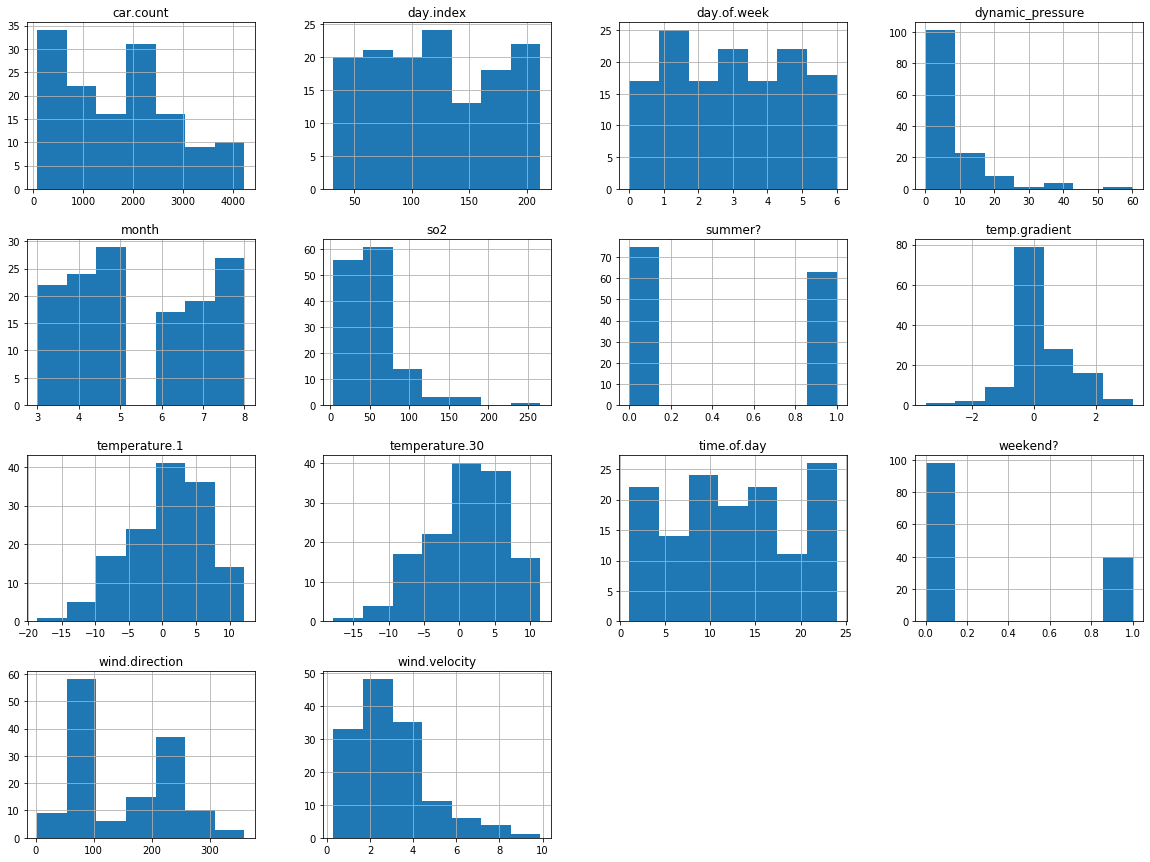

In [0]:
import matplotlib.pyplot as plt
training_df.hist(bins=7, figsize=(20,15))
plt.show()

In [0]:
# Create a new feature to indicate whether the SO2 reading was made during work hours (8 AM - 5 PM, Mo-Fr)

training_df["working.hours"] = 0
training_df["working.hours"] = np.where((training_df["time.of.day"] >= 8) & (training_df["time.of.day"] <= 18) & (training_df["weekend?"] == 0), 1, 0)

testing_df["working.hours"] = 0
testing_df["working.hours"] = np.where((testing_df["time.of.day"] >= 8) & (testing_df["time.of.day"] <= 18) & (testing_df["weekend?"] == 0), 1, 0)

training_df

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30,dynamic_pressure,month,temp.gradient,summer?,day.of.week,weekend?,working.hours
0,169.099957,1430.000396,1.3,114,21,50,-1.7,-0.3,1.035125,3,1.4,0,0,0,0
1,51.000223,2328.990055,2.5,83,20,98,-5.4,-4.0,3.828125,5,1.4,0,6,1,0
2,20.299982,2884.999484,2.2,44,18,189,9.8,9.8,2.964500,8,0.0,1,6,1,0
3,68.799742,3542.011269,5.9,214,16,108,4.2,4.5,21.321125,5,0.3,0,2,0,1
4,82.000062,2531.000606,0.5,296,15,184,8.9,8.3,0.153125,8,-0.6,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,100.200181,2497.011760,2.3,8,15,44,3.4,3.9,3.240125,3,0.5,0,1,0,1
291,64.900154,2583.008283,3.5,77,7,185,6.3,6.2,7.503125,8,-0.1,1,2,0,0
292,72.000279,3855.014318,5.5,216,17,193,11.0,10.0,18.528125,8,-1.0,1,3,0,1
297,23.400093,338.001387,4.3,203,1,127,4.6,4.9,11.325125,6,0.3,1,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9278c79be0>,
      dtype=object)

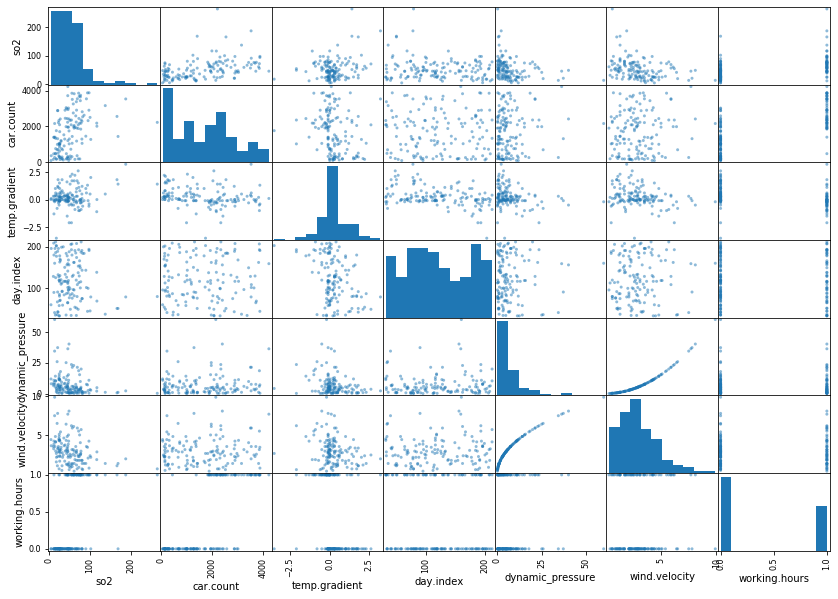

In [0]:
from pandas.plotting import scatter_matrix

attributes = ["so2","car.count", "temp.gradient", "day.index", "dynamic_pressure",
 "wind.velocity", "working.hours"] 
scatter_matrix(training_df[attributes], figsize=(14, 10))

In [0]:
# car.count appears to have a binomial relationship with SO2 so let's transorm it to a square root and drop the car.count column

training_df["car.root"] = training_df["car.count"]**0.5
testing_df["car.root"] = testing_df["car.count"]**0.5

training_df = training_df.drop(["car.count"], axis=1)
testing_df = testing_df.drop(["car.count"], axis=1)

In [0]:
corr_matrix = training_df.corr()
corr_matrix["so2"].sort_values(ascending=False)

so2                 1.000000
working.hours       0.482566
car.root            0.416617
temp.gradient       0.249283
time.of.day         0.030213
wind.direction     -0.030430
temperature.30     -0.087649
summer?            -0.119378
temperature.1      -0.121724
month              -0.141652
day.index          -0.144708
dynamic_pressure   -0.268077
weekend?           -0.327720
wind.velocity      -0.337294
day.of.week        -0.368543
Name: so2, dtype: float64

In [0]:
# Drop the low correlation covariates/variables 

#training_df = training_df.drop(["time.of.day"], axis=1)
# testing_df = testing_df.drop(["time.of.day"], axis=1)

training_df = training_df.drop(["wind.direction"], axis=1)
testing_df = testing_df.drop(["wind.direction"], axis=1)

training_df = training_df.drop(["temperature.1"], axis=1)
testing_df = testing_df.drop(["temperature.1"], axis=1)

training_df = training_df.drop(["temperature.30"], axis=1)
testing_df = testing_df.drop(["temperature.30"], axis=1)

training_df = training_df.drop(["day.index"], axis=1)
testing_df = testing_df.drop(["day.index"], axis=1)


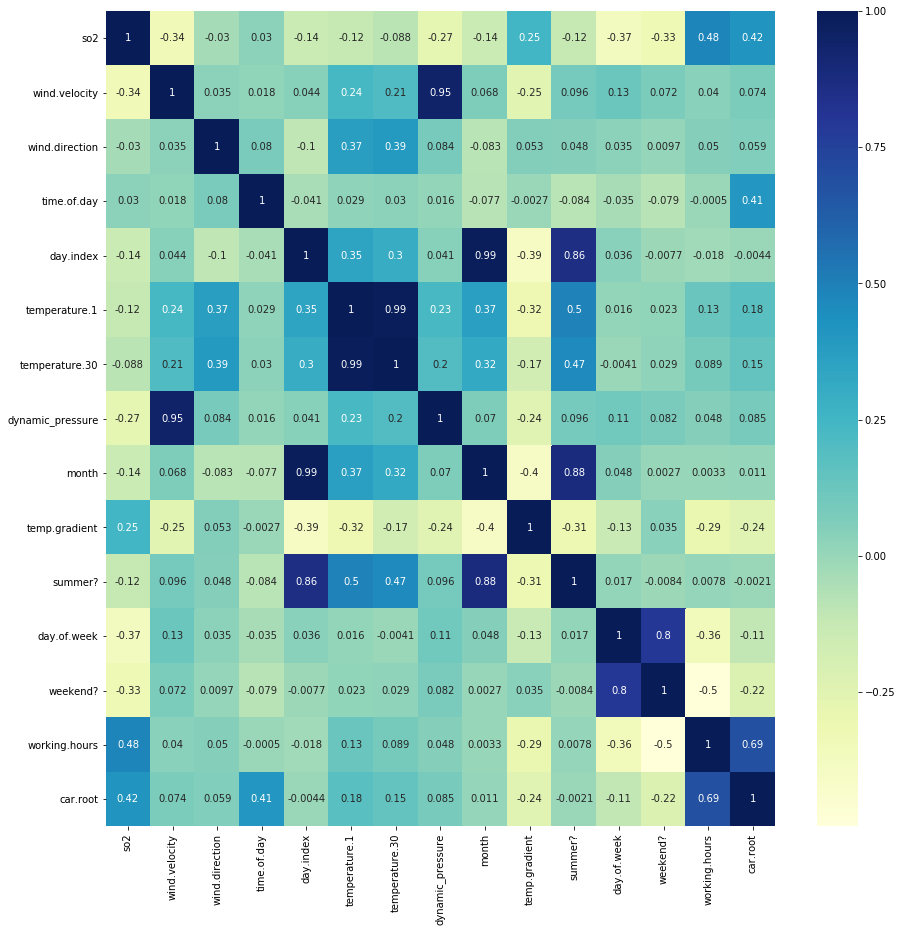

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15)) 

sns.heatmap(corr_matrix, annot=True,  ax=ax, cmap="YlGnBu")

In [0]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 298
Data columns (total 11 columns):
so2                 138 non-null float64
wind.velocity       138 non-null float64
time.of.day         138 non-null int64
dynamic_pressure    138 non-null float64
month               138 non-null int64
temp.gradient       138 non-null float64
summer?             138 non-null int64
day.of.week         138 non-null int64
weekend?            138 non-null int64
working.hours       138 non-null int64
car.root            138 non-null float64
dtypes: float64(5), int64(6)
memory usage: 12.9 KB


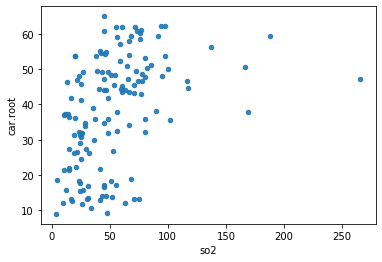

In [0]:
training_df.plot(kind="scatter", x="so2", y="car.root",
 alpha=0.9)

In [0]:
features = training_df.iloc[:,1:].values
labels = training_df.iloc[:,0].values

labels

array([169.09995673,  51.00022273,  20.29998201,  68.79974235,
        82.00006172,  24.09995564,  45.20013168,  48.29992462,
        70.89996926,  58.79989093,  45.30013443,  43.7998328 ,
        80.30003044,  31.20005944,  38.50006771,  41.29989675,
        34.1000892 ,  29.90004544,  36.30008199,  24.7999094 ,
        45.90022413,  32.4999971 , 137.59987265,  55.40002251,
        55.99990532,  22.19994919,  97.40036908,  60.99976429,
        76.19988854,  20.29998201,  20.49989983,  74.40030193,
         9.79997662,  17.10002627,  42.49982677,  46.90010902,
        48.70004723,  31.50007731,  23.40009308,  25.10005406,
        60.99976429,  74.8997086 ,  25.29988879,  16.99994315,
        46.49989246,  48.99998539,  45.39990443,  15.40003835,
        85.50030986,  54.29977048,  78.20002756,  37.69999644,
        11.1000543 ,  28.60009387,  19.70002688,  68.19968868,
        38.9999358 ,   4.50001171,  24.39992357, 166.50078098,
        66.9998245 ,  93.89996373,  14.70003684, 265.70

In [0]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(features,labels)

In [0]:
test = testing_df.values

X_train = model.predict(features)

so2_pred = model.predict(test)

prediction_df = pd.DataFrame({'Column1': so2_pred[:]})
prediction_df.to_csv('gdrive/My Drive/Colab Notebooks/so2_predictions.csv')

so2_pred

array([ 36.04768351,  54.0411439 ,  15.32491936,  87.2925291 ,
        13.27502862, 102.99763057,  54.51175289,  25.92278719,
        72.0566969 ,  71.22007628,  36.15675752,  19.93529297,
        17.98276174,  51.05435907,  32.32127305,  79.90991735,
        49.89262186, 101.73335366,  17.98276174,  62.29213342,
       108.43134657,  62.69922344,  20.30676635,  55.1453408 ,
        45.72586765, 102.64309602,  19.44191631,  44.99884486,
        54.0411439 ,  62.29213342,   6.12983658,  35.29716158,
        61.5019187 ,  54.2344199 ,  58.56701599,  50.77914198,
        50.77500052,  87.2925291 ,  20.24124867,  50.77500052,
        33.77786627,  79.90991735,  15.32491936,  50.77500052,
        36.04768351,  55.1453408 ,  72.13637111,   8.47736038,
        19.6738585 ,  35.29716158,   6.12983658, 101.73335366,
       109.24585724,  35.29716158,  54.11212866,  54.51175289,
        66.75142345,  72.0566969 ,  67.96116777,  44.34422629,
        51.05435907, 114.34038227,  55.1453408 ,  66.60

In [0]:
print(model.coef_)
print("\n")
print(model.intercept_)

[-13.49519327  -0.51065089   1.64582086   0.19032766  13.76008148
  -0.40873709  -2.99050541   2.04245547  24.81130055   0.74343056]


53.81648396418622


In [0]:
print("R^2 :", model.score(features, labels))
print("")

R^2 : 0.5303017156628931



In [0]:
import statsmodels.api as sm

X = training_df[["wind.velocity", "time.of.day", "dynamic_pressure", "month", 
                 "temp.gradient", "summer?", "day.of.week", "weekend?", "working.hours", "car.root"]]
y = training_df['so2']

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    so2   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     14.34
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           9.56e-17
Time:                        23:22:41   Log-Likelihood:                -641.41
No. Observations:                 138   AIC:                             1305.
Df Residuals:                     127   BIC:                             1337.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               53.8165     16.666      3.229      0.002      20.837      86.796
wind.velocity      -13.4952      3.950     -3.416      0.001     -21.312      -5.678
time.of.day         -0.5107      0.406     -1.257      0.211      -1.315       0.293
dynamic_pressure     1.6458      0.777      2.119      0.036       0.109       3.182
month                0.1903      2.881      0.066      0.947      -5.512       5.892
temp.gradient       13.7601      3.102      4.436      0.000       7.622      19.898
summer?             -0.4087      9.625     -0.042      0.966     -19.456      18.638
day.of.week         -2.9905      1.990     -1.503      0.135      -6.929       0.948
weekend?             2.0425      9.199      0.222      0.825     -16.160      20.245
working.hours       24.8113      8.574      2.894      0.004       7.846      41.777
car.root             0.7434      0.252      2.955      0.004       0.246       1.241
==============================================================================
Omnibus:                       79.592   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              489.151
Skew:                           1.966   Prob(JB):                    6.06e-107
Kurtosis:                      11.343   Cond. No.                         356.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Residual Plot: Training Set SO2')

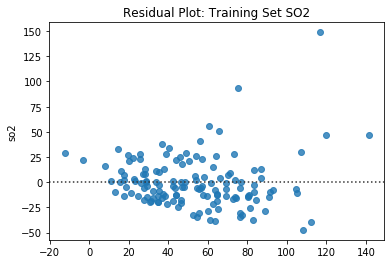

In [0]:
sns.residplot(X_train, y)
plt.title("Residual Plot: Training Set SO2")